# CartPole-v1
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

[Gym webpage](https://gym.openai.com/envs/CartPole-v1/)

In [ ]:
!pip install jdc
# !pip install tensorflow-gpu 

In [ ]:
import jdc
import gc
from PIL import Image

import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
device_name = None
if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
else:
    device_name = '/cpu:0'

print('Device: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Device: /cpu:0


In [ ]:
env_test = gym.make('CartPole-v1')
env_test.reset()

array([ 0.03854675, -0.00148384, -0.03925539, -0.03744224])

## Fully-Connected Q-network (FCQ)


In [ ]:
class FCQ(tf.keras.Model):
    def __init__(self, layers, activation_fc=tf.nn.relu) -> None:
        super(FCQ, self).__init__()
        self.layers_arr = []
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(4,), name="input_layer")
        for i, l in enumerate(layers):
            self.layers_arr.append(tf.keras.layers.Dense(l, activation=None if i==len(layers)-1 else activation_fc, name="dense_"+str(i)))
        self.build((None, 4))


    def call(self, inputs):
        x = self.input_layer(inputs)
        for layer in self.layers_arr:
            x = layer(x)
        return x


    def train_step(self, data):
        states, q_targets, actions = data
        with tf.GradientTape() as tape:
            q_states = self.call(states)
            q_state_action = tf.gather(q_states, actions, axis=1, batch_dims=1)

            loss = self.compiled_loss(q_targets, q_state_action)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(q_targets, q_state_action)
        return {m.name: m.result() for m in self.metrics}


In [ ]:
f = FCQ((512,128,2))
f.summary()

Model: "fcq_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_0 (Dense)              multiple                  2560      
_________________________________________________________________
dense_1 (Dense)              multiple                  65664     
_________________________________________________________________
dense_2 (Dense)              multiple                  258       
_________________________________________________________________
input_layer (InputLayer)     [(None, 4)]               0         
Total params: 68,482
Trainable params: 68,482
Non-trainable params: 0
_________________________________________________________________


## Neural Fitted Q-iteration (NFQ)

In [ ]:
class NFQ:
    def __init__(self, env, fcq, epsilon=0.5, gamma=1, batch_size=1024, epochs=40, evaluate_episodes=1) -> None:
        self.fcq = fcq
        self.env = env
        self.batch_size = batch_size
        self.epochs = epochs
        self.gamma = gamma
        
        self.epsilon = epsilon
        self.evaluate_episodes = evaluate_episodes

In [ ]:
%%add_to NFQ

def evaluate(self):
    rewards = 0.0
    for i in range(self.evaluate_episodes):
        state = self.env.reset()
        while True:
            action = self.greedy_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards += reward
            if done:
                break
            state = state_p
    return rewards / self.evaluate_episodes

In [ ]:
%%add_to NFQ

def train(self, n_episodes):
    # 1. get a batch of experiences
    # loop 1->k:
    #   2. calculate target
    #   3. fit Q values with RMSprops & MSE
    # goto 1
    experiences = []
    step_count = 0
    rewards = np.zeros(n_episodes)
    eval_rewards = np.zeros(n_episodes)
    for i in range(n_episodes):
        state = self.env.reset()
        while True:
            step_count += 1
            action = self.epsilon_greedy_exp_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards[i] += reward
            is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            experiences.append((state, action, reward, state_p, float(is_failure)))

            if len(experiences) >= self.batch_size:
                experiences = np.array(experiences, dtype=object)
                batches = [np.vstack(s) for s in experiences.T]
                self.optimize(batches)
                experiences = []

            if done:
                break
            print("\rEpisode: {}, Steps: {}, Reward:{}".format(i, step_count, rewards[i]), end="")
            state = state_p
        eval_rewards[i] = self.evaluate()
    return rewards, eval_rewards


In [ ]:
%%add_to NFQ

def epsilon_greedy_exp_policy(self, state):
    q_values = self.fcq.predict(np.expand_dims(state, axis=0))[0]
    if np.random.rand() < self.epsilon:
        action = np.random.randint(len(q_values))
    else:
        action = np.argmax(q_values)
    return action

def greedy_policy(self, state):
    q_values = self.fcq.predict(np.expand_dims(state, axis=0))
    return np.argmax(q_values)


In [ ]:
%%add_to NFQ

def optimize(self, batches):
    states, actions, rewards, states_p, is_terminals = batches
    q_states_p = self.fcq(states_p)
    max_q_states_p = tf.reduce_max(q_states_p, axis=1, keepdims=True)
    
    q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    for _ in range(self.epochs):
        self.fcq.train_step((states, q_targets, actions))

In [ ]:
env = gym.make("CartPole-v1")
fcq = FCQ((512,128,2))
fcq.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())
agent_nfq = NFQ(env, fcq, epsilon=0.5)
rewards_nfq, eval_rewards_nfq = agent_nfq.train(2000)

Episode: 999, Steps: 65914, Reward:20.0

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f95ba0c1680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Episode: 1014, Steps: 67471, Reward:125.0

KeyboardInterrupt: ignored

In [ ]:
np.save("rewards_nfq", rewards_nfq)
fcq.save_weights('./weights/fcq')
fcq.save_weights('./fcq.h5')
np.save("eval_rewards_nfq", eval_rewards_nfq)

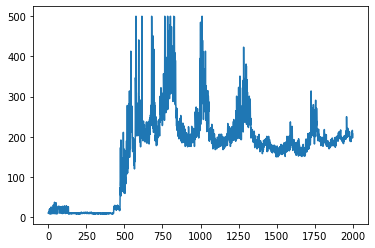

In [ ]:
plt.plot(eval_rewards_nfq)
plt.show()

## Deep Q-Network (DQN)

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size=50000) -> None:
        self.max_size = max_size
        self.next = 0
        self.size = 0

        self.states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rewards = np.empty(shape=(max_size), dtype=np.ndarray)
        self.states_p = np.empty(shape=(max_size), dtype=np.ndarray)
        self.is_terminals = np.empty(shape=(max_size), dtype=np.ndarray)

    def __len__(self): return self.size
    
    def store(self, experience):
        state, action, reward, state_p, is_terminal = experience
        self.states[self.next] = state
        self.actions[self.next] = action
        self.rewards[self.next] = reward
        self.states_p[self.next] = state_p
        self.is_terminals[self.next] = is_terminal

        self.next += 1
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=64):
        indices = np.random.choice(self.size, size=batch_size, replace=False)
        return np.vstack(self.states[indices]), \
            self.actions[indices], \
            self.rewards[indices], \
            np.vstack(self.states_p[indices]), \
            self.is_terminals[indices]


In [ ]:
%%add_to FCQ

def train_step(self, data):
    states, q_targets, actions = data
    with tf.GradientTape() as tape:
        q_states = self.call(states)
        q_state_action = tf.gather(q_states, actions, axis=1, batch_dims=1)
        loss = self.compiled_loss(q_targets, q_state_action)

    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    self.compiled_metrics.update_state(q_targets, q_state_action)
    return {m.name: m.result() for m in self.metrics}

In [ ]:
class DQN:
    def __init__(self, env, rb, online_nn, target_nn, gamma=1, min_buffer=320, network_update_rate=15) -> None:
        self.epsilon = 1
        self.min_epsilon = 0.1
        self.decay_rate = np.exp(np.log(self.min_epsilon) / 20_000) 
        self.gamma = gamma

        self.min_buffer = min_buffer
        self.network_update_rate = network_update_rate

        self.env = env
        self.replay_buffer = rb
        self.online_nn = online_nn
        self.target_nn = target_nn        


In [ ]:
%%add_to DQN

def epsilon_greedy_exp_policy(self, state):
    q_values = self.online_nn.predict(np.expand_dims(state, axis=0))[0]
    if np.random.rand() < self.epsilon:
        action = np.random.randint(len(q_values))
    else:
        action = np.argmax(q_values)
    self.epsilon = max(self.min_epsilon, self.decay_rate * self.epsilon)
    return action

In [ ]:
%%add_to DQN

def greedy_policy(self, state):
    q_values = self.online_nn.predict(np.expand_dims(state, axis=0))[0]
    action = np.argmax(q_values)
    return action

In [ ]:
%%add_to DQN

def optimize(self, batches):
    states, actions, rewards, states_p, is_terminals = batches
    q_states_p = self.target_nn(states_p)
    q_states_online = self.online_nn(states)

    max_q_states_p = tf.reduce_max(q_states_p, axis=1)
    q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)

    self.online_nn.train_step((states, q_targets, actions))

In [ ]:
%%add_to DQN

def train(self, n_episodes):
    step_count = 0
    rewards = np.zeros(n_episodes)
    for i in tqdm(range(n_episodes)):
        state = self.env.reset()
        while True:
            step_count += 1
            action = self.epsilon_greedy_exp_policy(state)
            state_p, reward, done, info = self.env.step(action)
            rewards[i] += reward
            is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
            is_failure = done and not is_truncated
            self.replay_buffer.store((state, action, reward, state_p, float(is_failure)))

            if len(self.replay_buffer) >= self.min_buffer:
                batches = self.replay_buffer.sample()
                self.optimize(batches)

            if step_count % self.network_update_rate == 0:
                self.target_nn.set_weights(self.online_nn.get_weights())

            if done:
                break
            # print("\rEpisode: {}, Steps: {}, eps: {:.3f}, Reward:{}".format(i, step_count, self.epsilon, rewards[i]), end="")

            state = state_p
    return rewards


In [ ]:
%%add_to DQN

def play(self):
    state = self.env.reset()
    frames = []
    while True:
        frames.append(Image.fromarray(env.render(mode='rgb_array')))

        action = self.greedy_policy(state)
        state_p, reward, done, info = self.env.step(action)

        if done:
            break

        state = state_p
    env.close()
    return frames

In [ ]:
env = gym.make("CartPole-v1")
rb = ReplayBuffer()
dqn_online_nn = FCQ((512,128,2))
dqn_target_nn = FCQ((512,128,2))

dqn_online_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())
dqn_target_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())

dqn = DQN(env, rb, dqn_online_nn, dqn_target_nn)
rewards_dqn = dqn.train(250)

100%|██████████| 250/250 [37:51<00:00,  9.09s/it]


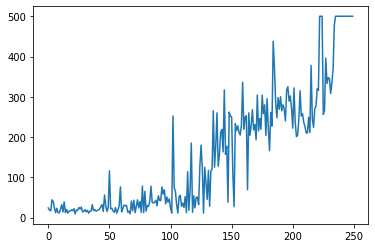

In [ ]:
plt.plot(rewards_dqn)
plt.show()

In [ ]:
frames = dqn.play()

In [ ]:
with open('./openai_gym.gif', 'wb') as f:
    im = Image.new('RGB', frames[0].size)
    im.save(f, save_all=True, append_images=frames)

<img width="400" height="auto" src="cartpole-v1-dqn.gif" alt="cartpole-v1-dqn"/>

## Double DQN (DDQN)

In [ ]:
class DDQN(DQN):
    def optimize(self, batches):
        states, actions, rewards, states_p, is_terminals = batches
        q_states_p = self.target_nn(states_p)
        q_states_p_online = self.online_nn(states_p)

        actions_p = tf.argmax(q_states_p_online, axis=1)
        max_q_states_p = tf.gather(q_states_p, actions_p, axis=1, batch_dims=1)

        q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)

        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        self.online_nn.train_step((states, q_targets, actions))

In [ ]:
env = gym.make("CartPole-v1")
rb = ReplayBuffer()
online_nn = FCQ((512,128,2))
target_nn = FCQ((512,128,2))

online_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())
target_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())

ddqn = DDQN(env, rb, online_nn, target_nn)
rewards_ddqn = ddqn.train(250)

100%|██████████| 250/250 [48:41<00:00, 11.69s/it]


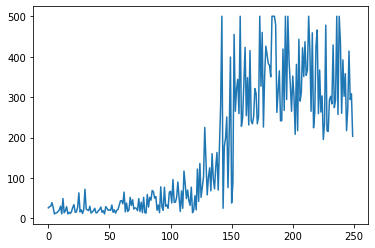

In [ ]:
plt.plot(rewards_ddqn)
plt.show()

In [ ]:
online_nn.save_model("ddqn_online_nn.h5")
target_nn.save_model("ddqn_target_nn.h5")

## Dueling DDQN

In [ ]:
class DuelingFCQ(tf.keras.Model):
    def __init__(self, layers, n_actions, activation_fc='relu') -> None:
        super(DuelingFCQ, self).__init__()
        self.layers_arr = []
        for i, layer in enumerate(layers):
            self.layers_arr.append(tf.keras.layers.Dense(layer, activation=activation_fc, name=("dense_"+str(layer))))
        self.advantage_layer = tf.keras.layers.Dense(n_actions, activation=None)
        self.value_layer = tf.keras.layers.Dense(1, activation=None)

        self.optimizer = tf.keras.optimizers.RMSprop(0.0005)
        self.loss = tf.keras.losses.MeanSquaredError()

        self.call(np.expand_dims(env.reset(), axis=0))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_arr:
            x = layer(x)
        value = self.value_layer(x)
        advantages = self.advantage_layer(x)

        Q = value + (advantages - tf.reduce_mean(advantages, axis=1, keepdims=True))
        return Q

    def train_step(self, data):
        states, q_targets, actions = data
        with tf.GradientTape() as tape:
            q_states = self.call(states)
            q_state_action = tf.gather(q_states, actions, axis=1, batch_dims=1)
            loss = self.compiled_loss(q_targets, q_state_action)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(q_targets, q_state_action)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
env = gym.make("CartPole-v1")
rb = ReplayBuffer()
dddqn_online_nn = DuelingFCQ((512,128), 2)
dddqn_target_nn = DuelingFCQ((512,128), 2)

dddqn_online_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())
dddqn_target_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005), loss=tf.keras.losses.MeanSquaredError())

dddqn = DDQN(env, rb, dddqn_online_nn, dddqn_target_nn)
rewards_dddqn = dddqn.train(250)

In [ ]:
plt.plot(rewards_dddqn)
plt.show()

In [ ]:
dddqn_online_nn.save_model("dddqn_online_nn.h5")
dddqn_target_nn.save_model("dddqn_target_nn.h5")

## DDDQN + Prioratized Experience Replay (PER)

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size=50000, alpha=0.6, beta0=0.1, beta_rate=0.99992) -> None:
        self.max_size = max_size
        self.next = 0
        self.size = 0

        self.states = np.empty(shape=(max_size), dtype=np.ndarray)
        self.actions = np.empty(shape=(max_size), dtype=np.int16)
        self.rewards = np.empty(shape=(max_size), dtype=np.ndarray)
        self.states_p = np.empty(shape=(max_size), dtype=np.ndarray)
        self.is_terminals = np.empty(shape=(max_size), dtype=np.bool_)

        self.td_errors = np.empty(shape=(max_size), dtype=np.float64)
        self.alpha = alpha
        self.beta = beta0
        self.beta0 = beta0
        self.beta_rate = beta_rate**(-1)
        self.EPSILON = 1e-6

    def __len__(self): return self.size

    def update(self, indices, td_errors):
        self.td_errors[indices] = np.abs(td_errors)

    def update_beta(self):
        self.beta = min(1.0, self.beta * self.beta_rate)


In [ ]:
%%add_to PrioritizedReplayBuffer

def sample(self, batch_size=64):
    self.update_beta()

    priorities = self.td_errors[:self.size] + self.EPSILON
    scaled_priorities = np.power(priorities, self.alpha)        
    probs = scaled_priorities / np.sum(scaled_priorities)

    weights = np.power((self.size * probs), -self.beta)
    normalized_weights = weights/weights.max()

    indices = np.random.choice(self.size, size=batch_size, replace=False, p=probs)
    return \
        indices, \
        normalized_weights[indices], \
        np.vstack(self.states[indices]), \
        self.actions[indices], \
        self.rewards[indices], \
        np.vstack(self.states_p[indices]), \
        self.is_terminals[indices]

In [ ]:
%%add_to PrioritizedReplayBuffer

def store(self, experience):
    priority = 1.0
    if self.size > 0:
        priority = self.td_errors.max()

    state, action, reward, state_p, is_terminal = experience
    self.states[self.next] = state
    self.actions[self.next] = action
    self.rewards[self.next] = reward
    self.states_p[self.next] = state_p
    self.is_terminals[self.next] = is_terminal
    self.td_errors[self.next] = priority

    self.next += 1
    self.size = min(self.size + 1, self.max_size)
    self.next = self.next % self.max_size

In [ ]:
class PER_DDDQN(DQN):
    def optimize(self, batches):
        indices, weights, states, actions, rewards, states_p, is_terminals = batches
        q_states_p = self.target_nn(states_p)
        q_states_p_online = self.online_nn(states_p)

        actions_p = tf.argmax(q_states_p_online, axis=1)
        max_q_states_p = tf.gather(q_states_p, actions_p, axis=1, batch_dims=1)

        q_targets = rewards + self.gamma * max_q_states_p * (1 - is_terminals)

        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        td_errors = self.online_nn.train_step((states, q_targets, actions, weights))
        self.replay_buffer.update(indices, td_errors)

In [ ]:
class PER_DuelingFCQ(DuelingFCQ):
    def train_step(self, data):
        states, q_targets, actions, weights = data
        with tf.GradientTape() as tape:
            q_states = self.call(states)
            q_state_action = tf.gather(q_states, actions, axis=1, batch_dims=1)
            td_errors = q_targets - q_state_action
            loss = tf.reduce_mean(tf.square(weights * td_errors))

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.compiled_metrics.update_state(q_targets, q_state_action)
        return td_errors

In [ ]:
env = gym.make("CartPole-v1")
rb = PrioritizedReplayBuffer()
dddqn_online_nn = PER_DuelingFCQ((512,128), 2)
dddqn_target_nn = PER_DuelingFCQ((512,128), 2)

dddqn_online_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005))
dddqn_target_nn.compile(optimizer=tf.keras.optimizers.RMSprop(0.0005))

dddqn = PER_DDDQN(env, rb, dddqn_online_nn, dddqn_target_nn)
rewards_dddqn = dddqn.train(250)












  0%|          | 0/250 [00:00<?, ?it/s]










  0%|          | 1/250 [00:00<01:39,  2.50it/s]










  1%|          | 2/250 [00:00<01:48,  2.28it/s]










  1%|          | 3/250 [00:02<03:09,  1.30it/s]










  2%|▏         | 4/250 [00:03<03:05,  1.32it/s]










  2%|▏         | 5/250 [00:04<03:40,  1.11it/s]










  2%|▏         | 6/250 [00:05<03:19,  1.22it/s]










  3%|▎         | 7/250 [00:07<05:02,  1.24s/it]










  3%|▎         | 8/250 [00:07<04:02,  1.00s/it]










  4%|▎         | 9/250 [00:08<03:47,  1.06it/s]










  4%|▍         | 10/250 [00:08<03:09,  1.27it/s]










  4%|▍         | 11/250 [00:09<02:58,  1.34it/s]










  5%|▍         | 12/250 [00:10<02:57,  1.34it/s]










  5%|▌         | 13/250 [00:11<03:20,  1.18it/s]










  6%|▌         | 14/250 [00:12<04:05,  1.04s/it]










  6%|▌         | 15/250 [00:14<04:40,  1.19s/it]










  6%|▋         | 16/250 [00:15<04:54,  1.26s/it]










  7%

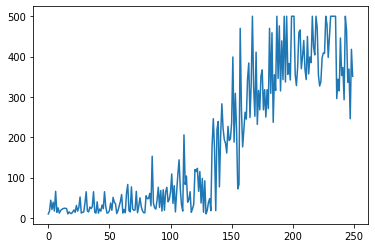

In [ ]:
plt.plot(rewards_dddqn)
plt.show()